# Comittee of CNNs

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random
from skimage.transform import SimilarityTransform, resize, warp, rotate, rescale
from skimage import data
import math
import time

Keras

In [2]:
from keras.utils.np_utils import to_categorical
from keras.utils import Sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, Callback

Using TensorFlow backend.


## Pickle handler

In [3]:
class ModelSaver:
    def __init__(self, name = 'model', model = None):
        self.model = model
        self.fileName = name + '.pickle'
    def save(self, model = None):
        if (model == None):
            model = self.model
        pickle.dump(model, open(self.fileName, 'wb'))
    def load(self):
        model = pickle.load(open(self.fileName, 'rb'))
        return model

## Loading up the data

In [4]:
path = './data/'
modelSaver = ModelSaver(path + 'preprocessed_hist')

In [5]:
data = modelSaver.load()

In [6]:
data['x']['train'].keys()

dict_keys(['simple', 'stretch', 'eq', 'adeq', 'hog'])

In [7]:
labels = data['labels']

yTrain = to_categorical(data['y']['train'], num_classes=43)
yTest = to_categorical(data['y']['test'], num_classes=43)
yValid = to_categorical(data['y']['valid'], num_classes=43)

xTrainSimple = data['x']['train']['simple']
xTestSimple = data['x']['test']['simple']
xValidSimple = data['x']['valid']['simple']

xTrainStretch = data['x']['train']['stretch']
xTestStretch = data['x']['test']['stretch']
xValidStretch = data['x']['valid']['stretch']

xTrainEq = data['x']['train']['eq']
xTestEq = data['x']['test']['eq']
xValidEq = data['x']['valid']['eq']

xTrainAdEq = data['x']['train']['adeq']
xTestAdEq = data['x']['test']['adeq']
xValidAdEq = data['x']['valid']['adeq']

xTrainHOG = np.array(data['x']['train']['hog'])
xTestHOG = np.array(data['x']['test']['hog'])
xValidHOG = np.array(data['x']['valid']['hog'])

In [24]:
np.array(xTrainHOG).shape

(39209, 5000)

In [8]:
def showImage(img):
    low, high = np.min(img), np.max(img)
    img = (img - low) / (high - low)
    plt.imshow(img.astype('float32'), cmap=plt.get_cmap('gray_r'))
    plt.show()

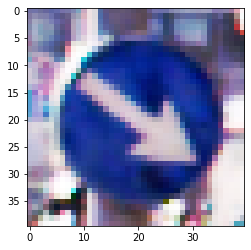

In [9]:
showImage(xTrainEq[0])

## Training methods

In [10]:
def transform(img, translation=(0, 0), rotation=0.0, scale=1.0):
    translation = (translation[0] + img.shape[0] / 2 * (1 - scale), translation[1] + img.shape[1] / 2 * (1 - scale))
    transform = SimilarityTransform(translation=translation, scale=scale)
    rotated = rotate(img, rotation, mode='reflect')
    return warp(rotated, transform, mode='reflect')
    
def applyRandomTransformation(img):
    dx = random.randint(-2, 2)
    dy = random.randint(-2, 2)
    dphi = random.uniform(-7, 7)
    dscale = random.uniform(0.8, 1.2)
    return transform(img, (dx, dy), dphi, dscale)

def transformImages(imgs):
    return np.array([applyRandomTransformation(img) for img in imgs]) 

In [11]:
class Generator(Sequence):
    # Class is a dataset wrapper for better training performance
    def __init__(self, x_set, y_set, batch_size=12):
        self.x, self.y = x_set, y_set
        self.orig_x, self.orig_y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(self.x.shape[0] / self.batch_size)

    def __getitem__(self, idx):
        low, high = idx * self.batch_size, (idx + 1) * self.batch_size
        batch_x = self.x[low:high]
        batch_y = self.y[low:high]
        return batch_x, batch_y
    
    def on_epoch_end(self):
        print('Transforming images')
        start = time.time()
        self.x = transformImages(self.orig_x)
        end = time.time()
        print(int(end - start), 's')

In [10]:
class CNN:
    def __init__(self):
        self.model = self.getModel()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
    def getModel(self):
        model = Sequential()
        model.add(Conv2D(40, kernel_size=7, padding='same', activation='relu', input_shape=(40, 40, 3)))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(20, kernel_size=4, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Conv2D(10, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool2D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(300, activation='relu'))
        model.add(Dense(43, activation='softmax')) #hyperbolic tangent?
        return model
        
    def train(self, x, y, xValid, yValid):
        start = time.time()
        self.history = self.model.fit(
            Generator(x, y), epochs = 12,
            validation_data = (xValid, yValid),
            verbose=2)
        
        end = time.time()
        print('Training model took', int(end - start), 's')
    def evaluate(self, x, y):
        print('Accuracy:', self.model.evaluate(x, y, verbose=0)[1])
    
    def load(self, model):
        self.model = model

In [11]:
class MLP:
    def __init__(self):
        self.model = self.getModel()
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    def setModel(self, model):
        self.model = model
        

    def getModel(self):
        model = Sequential()
        model.add(Dense(1000, activation='relu', input_dim=5000))
        model.add(Dropout(0.33))
        model.add(Dense(300, activation='relu'))
        model.add(Dropout(0.33))
        model.add(Dense(43, activation='softmax'))
        return model
        
    def train(self, x, y, xValid, yValid):
        start = time.time()
        self.history = model.fit(x, y, epochs = 20,
            validation_data = (xValid, yValid),
            verbose=2)
        
        end = time.time()
        print('Training model took', int(end - start), 's')
    def evaluate(self, x, y):
        print('Accuracy:', self.model.evaluate(x, y, verbose=0)[1])
    
    def load(self, model):
        self.model = model

## Committee of CNNs

In [27]:
class Trainer():
    def __init__(self, dataSets):
        self.dataSets = dataSets
        self.models = [ CNN() for _ in dataSets ]
    def train(self):
        start = time.time()
        for i in range(0, len(self.dataSets)):
            print('Training model', i)
            self.models[i].train(self.dataSets[i][0], self.dataSets[i][1], 
                                 self.dataSets[i][2], self.dataSets[i][3])

        end = time.time()
        print('The whole process took', int(end - start), 's')
    def getCommittee(self):
        cCNN = CommitteeOfCNNs()
        for cnn in self.models:
            cCNN.addModel(cnn)
        return cCNN

In [18]:
class CommitteeOfCNNs():
    def __init__(self):
        self.models = []
        
    def addModel(self, model):
        self.models.append(model)
    
    def evaluate(self, dataSets):
        for i in range(0, len(dataSets)):
            self.models[i].evaluate(dataSets[i][4], dataSets[i][5])
    
    def predict(self, x):
        results = np.array([ self.models[i].model.predict(np.array([x[i]]))[0] for i in range(0, len(self.models)) ])
        votes = np.argmax(results, axis=1)
        winner = np.argmax(np.bincount(votes, minlength=43))
        return winner

    def test(self, x, y):
        x = self.transpose(x)
        y = np.argmax(y, axis=1)
        predictions = np.array([ self.predict(row) for row in x ])
        success = predictions == y
        accuracy = len(y[success]) / len(y)
        return accuracy
    
    def transpose(self, x):
        X = []
        for i in range(0, len(x[0])):
            X.append([None, None, None, None, None])
            
        for i in range(0, len(x)):
            for j in range(0, len(x[i])):
                X[j][i] = x[i][j]
        return X
    
    def save(self):
        for i in range(0, len(self.models)):
            self.models[i].model.save('models/model_committee%x.h5' % i)
    
    def load(self):
        self.models = []
        for i in range(0, 5):
            model = load_model('models/model_committee%x.h5' % i)
            cnn = CNN()
            cnn.load(model)
            self.addModel(cnn)

In [13]:
dataSets = np.array([
    [xTrainSimple,  yTrain, xValidSimple,  yValid, xTestSimple,  yTest],
    [xTrainStretch, yTrain, xValidStretch, yValid, xTestStretch, yTest],
    [xTrainEq,      yTrain, xValidEq,      yValid, xTestEq,      yTest],
    [xTrainAdEq,    yTrain, xValidAdEq,    yValid, xTestAdEq,    yTest],
    [xTrainHOG,     yTrain, xValidHOG,     yValid, xTestHOG,     yTest]
])

In [32]:
trainer = Trainer(dataSets)

In [19]:
trainer.train()

Training model 0
Epoch 1/12
Transforming images
 - 109s - loss: 0.5409 - accuracy: 0.8449 - val_loss: 0.3928 - val_accuracy: 0.9055
25 s
Epoch 2/12
Transforming images
 - 109s - loss: 0.3333 - accuracy: 0.8989 - val_loss: 0.2771 - val_accuracy: 0.9287
26 s
Epoch 3/12
Transforming images
 - 95s - loss: 0.1946 - accuracy: 0.9402 - val_loss: 0.3223 - val_accuracy: 0.9335
26 s
Epoch 4/12
Transforming images
 - 117s - loss: 0.1713 - accuracy: 0.9486 - val_loss: 0.2976 - val_accuracy: 0.9298
25 s
Epoch 5/12
Transforming images
 - 121s - loss: 0.1523 - accuracy: 0.9548 - val_loss: 0.3159 - val_accuracy: 0.9283
25 s
Epoch 6/12
Transforming images
 - 100s - loss: 0.1377 - accuracy: 0.9588 - val_loss: 0.2941 - val_accuracy: 0.9350
26 s
Epoch 7/12
Transforming images
 - 114s - loss: 0.1405 - accuracy: 0.9619 - val_loss: 0.3335 - val_accuracy: 0.9388
24 s
Epoch 8/12
Transforming images
 - 139s - loss: 0.1188 - accuracy: 0.9660 - val_loss: 0.2870 - val_accuracy: 0.9425
24 s
Epoch 9/12
Transforming 

In [35]:
mlp = MLP()
mlp.train()

In [88]:
model.addModel(mlp)

## Test and evaluation

In [ ]:
model = trainer.getCommittee()
model.evaluate(dataSets)

In [21]:
model.test([xTestSimple, xTestStretch, xTestEq, xTestAdEq, xTestHOG], yTest)

0.9828978622327791

In [22]:
def predictRandomImage():
    ix = random.randint(0, len(xTestSimple))
    img = [xTestSimple[ix], xTestStretch[ix], xTestEq[ix], xTestAdEq[ix], xTestHOG[ix]]
    showImage(img[2])
    y = np.argmax(yTest[ix])
    start = time.time()
    prediction = model.predict(img)
    end = time.time()
    print('Time elapsed:', int((end - start) * 1000), 'ms')
    print('Prediction:', labels[prediction])
    print('Actual:', labels[y])

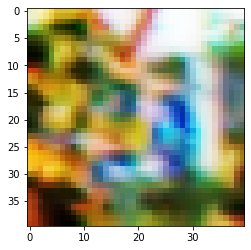

Time elapsed: 45 ms
Prediction: Priority road
Actual: Roundabout mandatory


In [25]:
predictRandomImage()

In [26]:
def showMissedImages(ixRange):
    for ix in ixRange:
        img = [xTestSimple[ix], xTestStretch[ix], xTestEq[ix], xTestAdEq[ix], xTestHOG[ix]]
        prediction = model.predict(img)
        actual = np.argmax(yTest[ix])
        if int(actual) is not int(prediction):
            showImage(img[2])
            print('Prediction:', labels[prediction])
            print('Actual:', labels[actual])

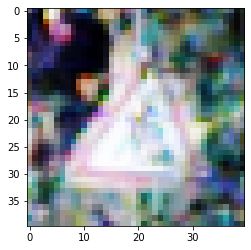

Prediction: Right-of-way at the next intersection
Actual: Road work


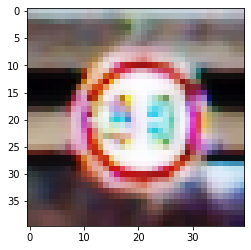

Prediction: Speed limit (30km/h)
Actual: Speed limit (80km/h)


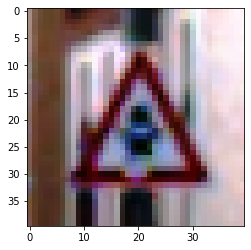

Prediction: Beware of ice/snow
Actual: Right-of-way at the next intersection


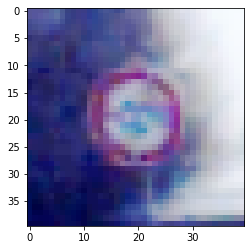

Prediction: Speed limit (70km/h)
Actual: Speed limit (120km/h)


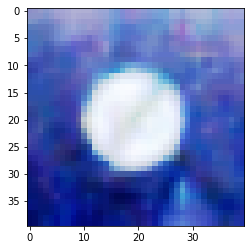

Prediction: Priority road
Actual: End of speed limit (80km/h)


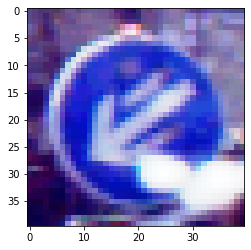

Prediction: Go straight or left
Actual: Keep left


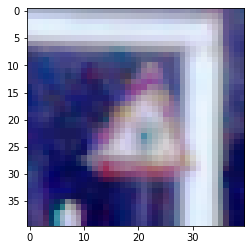

Prediction: Right-of-way at the next intersection
Actual: Beware of ice/snow


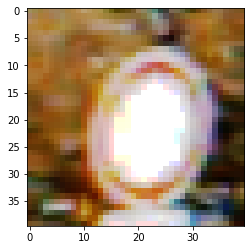

Prediction: Speed limit (50km/h)
Actual: No vehicles


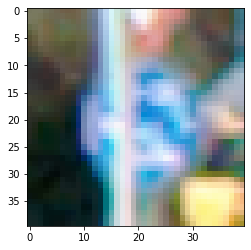

Prediction: Go straight or right
Actual: Roundabout mandatory


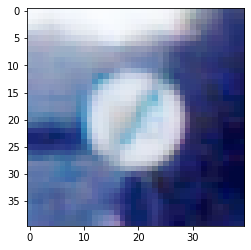

Prediction: Speed limit (70km/h)
Actual: End of speed limit (80km/h)


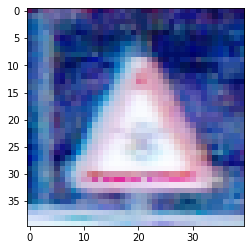

Prediction: Right-of-way at the next intersection
Actual: Beware of ice/snow


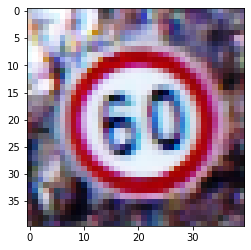

Prediction: Speed limit (80km/h)
Actual: Speed limit (60km/h)


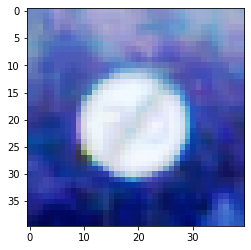

Prediction: End of no passing by vehicles over 3.5 metric tons
Actual: End of speed limit (80km/h)


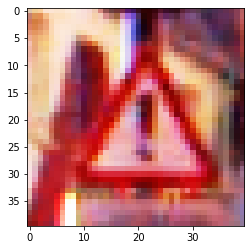

Prediction: Right-of-way at the next intersection
Actual: General caution


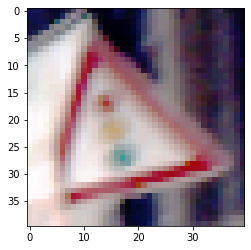

Prediction: Yield
Actual: Traffic signals


In [27]:
showMissedImages(range(0, len(xTestSimple[:1000])))

## Saving the model

In [90]:
model.save()

## Load model

In [ ]:
model = CommitteeOfCNNs()

In [ ]:
model.load()

In [16]:
model.evaluate(dataSets)

Accuracy: 0.9286619424819946
Accuracy: 0.8999208211898804
Accuracy: 0.948693573474884
Accuracy: 0.956136167049408
Accuracy: 0.9094220399856567
